In [251]:
%reload_ext autoreload
%autoreload 2


from src.helper_visualization import *

import sys
sys.path.append('../src/')

from config import *

In [252]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

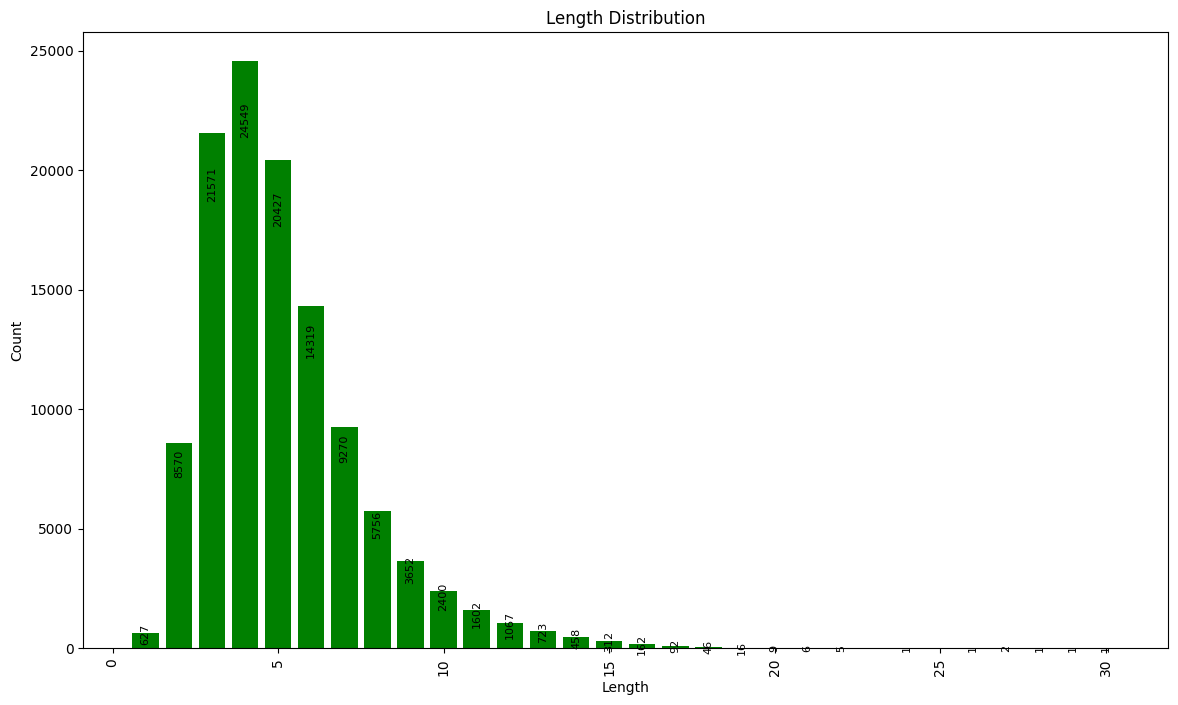

In [267]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned = pd.read_excel(excel_file)
hist_by_labels(df_cleaned, 'Length', log=False)

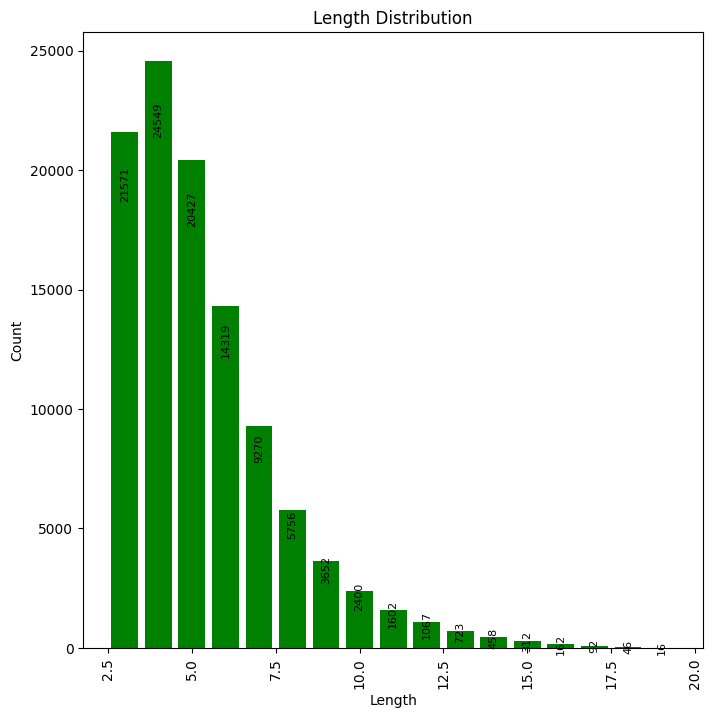

In [268]:
mask = (df_cleaned['Length'] >= 3) & (df_cleaned['Length'] < 20)
df_cleaned = df_cleaned[mask]
hist_by_labels(df_cleaned, 'Length')

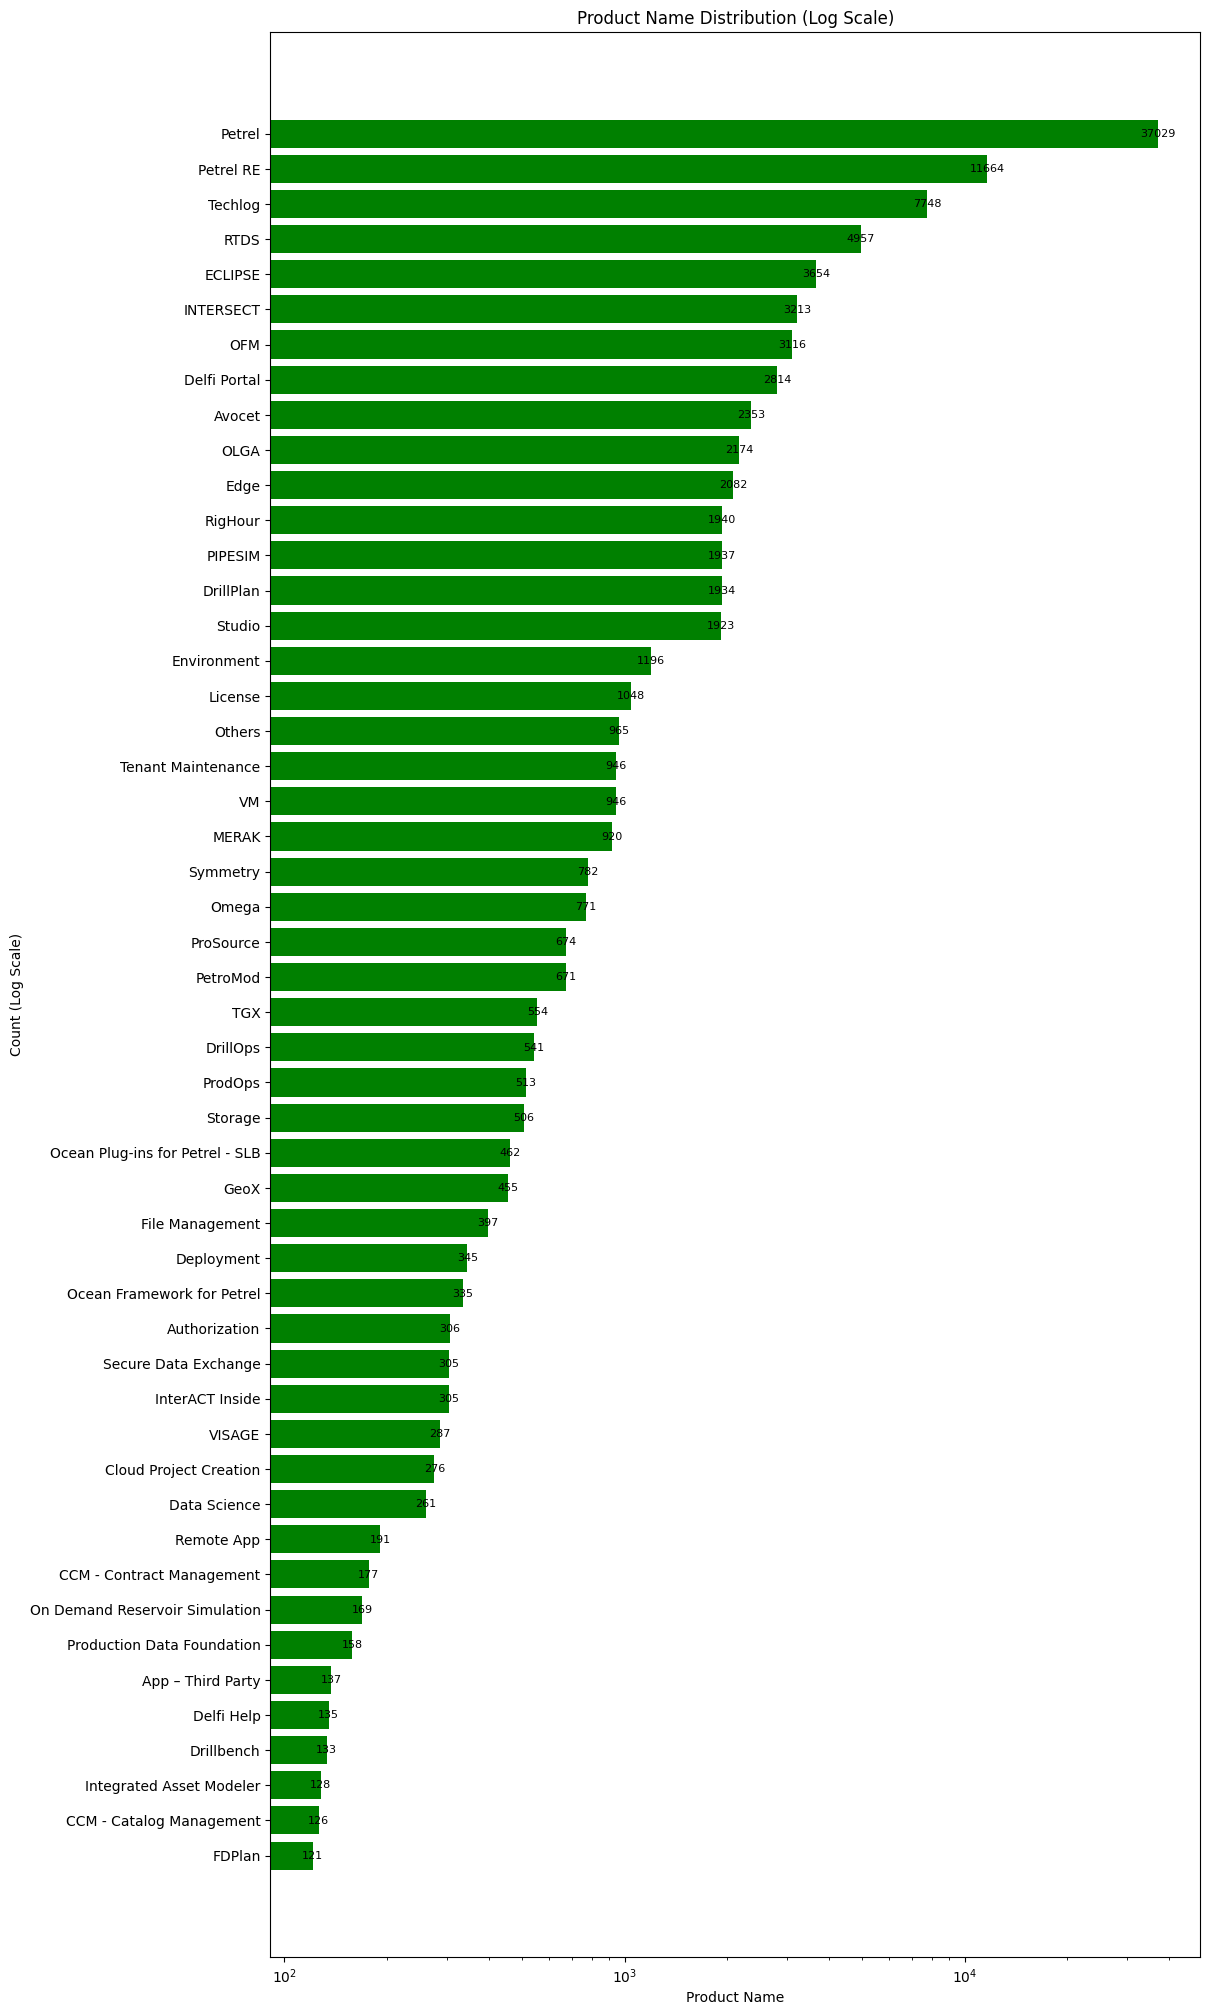

In [269]:
hist_by_labels(df_cleaned, 'Product Name', top=50, log=True, horizontal=False)

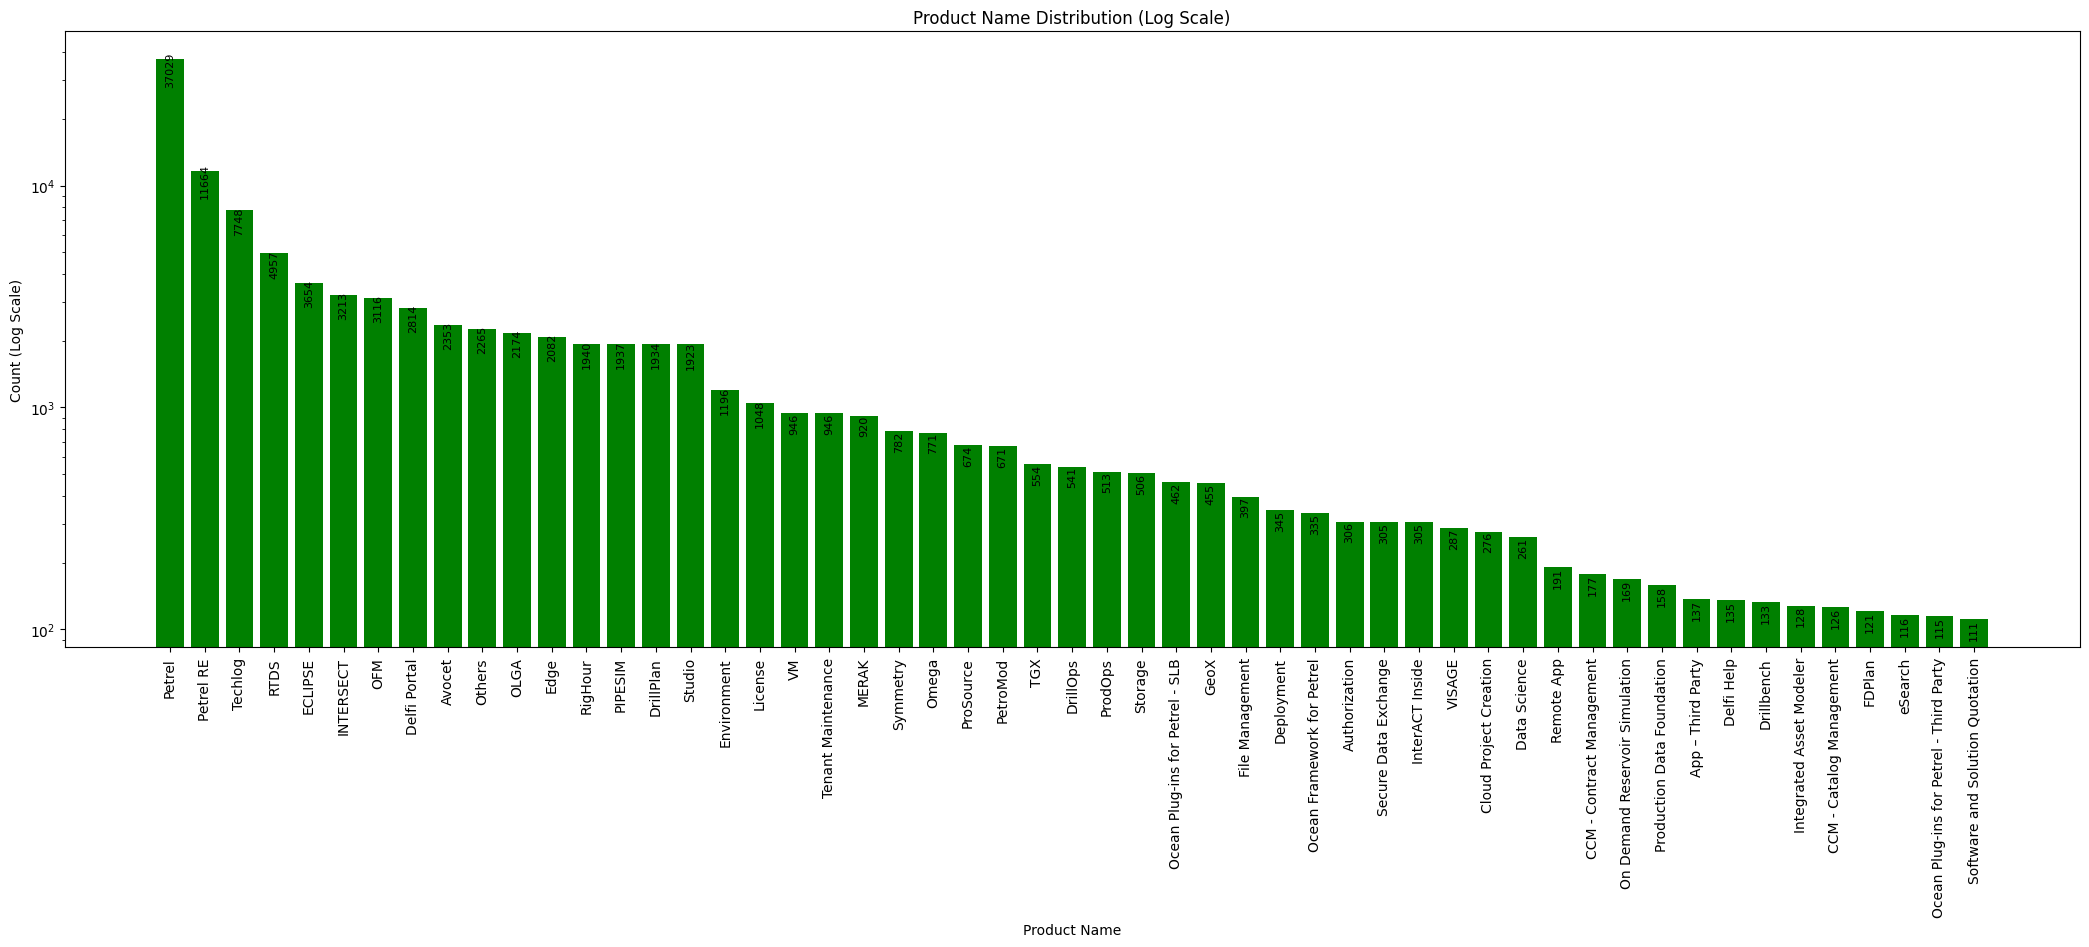

In [270]:
product_counts = df_cleaned['Product Name'].value_counts()
cutoff = 100
product_top = product_counts.index[product_counts >= cutoff]
product_long_tail = product_counts.index[product_counts < cutoff]

mask_others = df_cleaned['Product Name'].isin(product_long_tail)
df_cleaned.loc[mask_others,'Product Name']='Others'
hist_by_labels(df_cleaned, 'Product Name', log=True)

In [271]:
# Calculate the number of rows to select for the 10% portion
percent_to_select = 0.15
num_rows_to_select = int(len(df_cleaned) * percent_to_select)

# Randomly select 10% of the records
df_test = df_cleaned.sample(n=num_rows_to_select, random_state=42)  # Adjust 'random_state' as needed for reproducibility

# Create the other DataFrame containing the rest of the records
df_train = df_cleaned.drop(df_test.index)

# Step 1: Data Preparation
# Split the data into features (X) and target labels (y)
X = df_train['Title_Cleaned']

# Step 2: Word Embeddings with Count Vectorizer (FastText-like)
vectorizer = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer.fit(X)

CountVectorizer(max_features=20000, ngram_range=(1, 2))

In [ ]:
product_counts = df_train['Product Name'].value_counts()
product_others = product_counts.index[product_counts < 20000]

mask_others = df_train['Product Name'].isin(product_others)
df_petrel_or_not = df_train.copy()
df_petrel_or_not.loc[mask_others,'Product Name']='Others'

hist_by_labels(df_petrel_or_not, 'Product Name', log=False, horizontal=False)

In [ ]:
#Balance the dataset by reducing the records from Petrel
import random

# Calculate the number of 'abc' records to delete (2/3 of the total 'abc' records)
others_records = df_petrel_or_not[df_petrel_or_not['Product Name'] == 'Others']
records_to_delete = 27000

# Randomly select the indices of 'abc' records to delete
indices_to_delete = random.sample(others_records.index.tolist(), records_to_delete)

# Delete the selected rows from the DataFrame
df_petrel_or_not = df_petrel_or_not.drop(indices_to_delete)
hist_by_labels(df_petrel_or_not, 'Product Name', log=False, horizontal=False)

In [ ]:
# Step 1: Data Preparation
# Split the data into features (X) and target labels (y)
X = df_petrel_or_not['Title_Cleaned']
y = df_petrel_or_not['Product Name']

# # Step 2: Word Embeddings with Count Vectorizer (FastText-like)
# vectorizer = CountVectorizer(max_features=8000, analyzer='word', ngram_range=(1, 2))
# X_encoded = vectorizer.fit_transform(X)
X_encoded = vectorizer.transform(X)

# Step 3: Model Training (Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=42)

model_petrel_or_not = LogisticRegression(
    max_iter=5000
)
model_petrel_or_not.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred_petrel = model_petrel_or_not.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_petrel)
print(f"Accuracy: {accuracy:.3f}")

# Optionally, you can generate a classification report for more detailed metrics
report = classification_report(y_test, y_pred_petrel, digits=3)
print(report)
labels = model_petrel_or_not.classes_
plot_confusion_matrix(y_test, y_pred_petrel, labels, title='Confusion matrix for Petrel or Not')

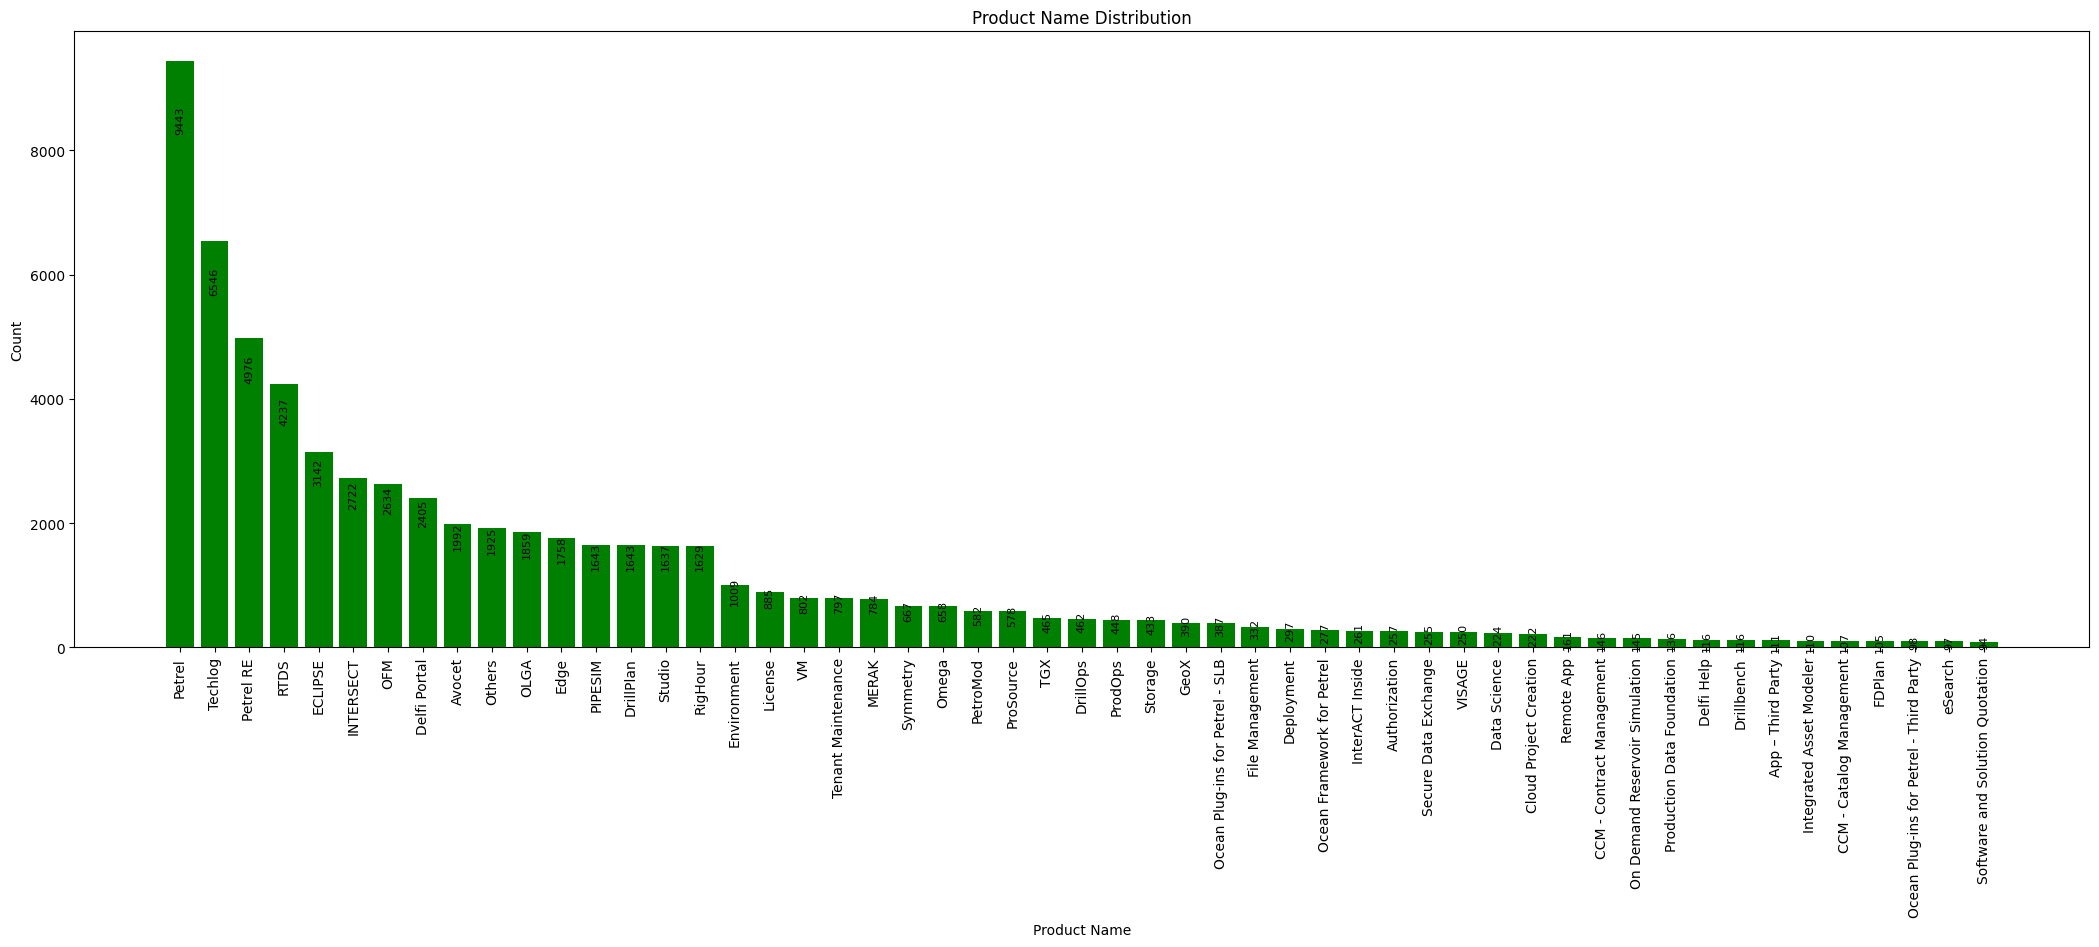

In [272]:
# mask_others = df_train['ProductName'].isin(product_others)
df_balanced = df_train.copy()
# hist_by_labels(df_rests, 'Product Name', log=True)

# Balance the dataset by reducing the records from Petrel
import random

# Calculate the number of 'Petrel' records to delete some records
petrel_records = df_balanced[df_balanced['Product Name'] == 'Petrel']
records_to_delete = len(petrel_records)//10*7
indices_to_delete = random.sample(petrel_records.index.tolist(), records_to_delete)
df_balanced = df_balanced.drop(indices_to_delete)

# Calculate the number of 'Petrel RE' records to delete some records
petrel_RE_records = df_balanced[df_balanced['Product Name'] == 'Petrel RE']
records_to_delete = len(petrel_RE_records)//2
indices_to_delete = random.sample(petrel_RE_records.index.tolist(), records_to_delete)
df_balanced = df_balanced.drop(indices_to_delete)


hist_by_labels(df_balanced, 'Product Name', top=None, log=False)

In [273]:
# Step 1: Data Preparation
# Split the data into features (X) and target labels (y)
X = df_balanced['Title_Cleaned']
y = df_balanced['Product Name']

# Step 2: Word Embeddings with Count Vectorizer (FastText-like)
# vectorizer = CountVectorizer(max_features=8000, analyzer='word', ngram_range=(1, 2))
# X_encoded = vectorizer.fit_transform(X)
X_encoded = vectorizer.transform(X)
# Step 3: Model Training (Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=42)

# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_balanced = LogisticRegression(
    max_iter=5000,
    # class_weight= weights
)
model_balanced.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred_others = model_balanced.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_others)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_others, digits=3)
print(report)


Accuracy: 0.730
                                         precision    recall  f1-score   support

                      App – Third Party      0.750     0.188     0.300        16
                          Authorization      0.700     0.636     0.667        22
                                 Avocet      0.775     0.788     0.781       179
               CCM - Catalog Management      0.556     0.455     0.500        11
              CCM - Contract Management      0.571     0.333     0.421        12
                 Cloud Project Creation      0.882     0.682     0.769        22
                           Data Science      0.733     0.733     0.733        15
                             Delfi Help      0.000     0.000     0.000        12
                           Delfi Portal      0.476     0.597     0.530       236
                             Deployment      0.750     0.484     0.588        31
                               DrillOps      0.891     0.745     0.812        55
           

/Users/haitao/anaconda3/envs/CCC/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/anaconda3/envs/CCC/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/anaconda3/envs/CCC/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [293]:

# save the model to disk
import pickle
filename = f'../models/model_balanced.sav'
pickle.dump(model_balanced, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
def predictions_2L(predictions_petrel, predictions_others):
    predictions = predictions_others.copy()
    for i in range(len(predictions)):
        if predictions_petrel[i] == 'Petrel':
            predictions[i] = 'Petrel'
    return predictions

Accuracy: 0.757
                                 precision    recall  f1-score   support

                         Avocet      0.777     0.745     0.761       361
                   Delfi Portal      0.483     0.474     0.478       409
                       DrillOps      0.776     0.658     0.712        79
                      DrillPlan      0.860     0.718     0.783       291
                        ECLIPSE      0.554     0.508     0.530       512
                           Edge      0.994     0.954     0.973       324
                    Environment      0.314     0.176     0.226       187
                           GeoX      0.754     0.754     0.754        65
                      INTERSECT      0.675     0.523     0.589       491
                        License      0.485     0.405     0.441       163
                          MERAK      0.945     0.757     0.841       136
                            OFM      0.915     0.844     0.878       482
                           OLGA   

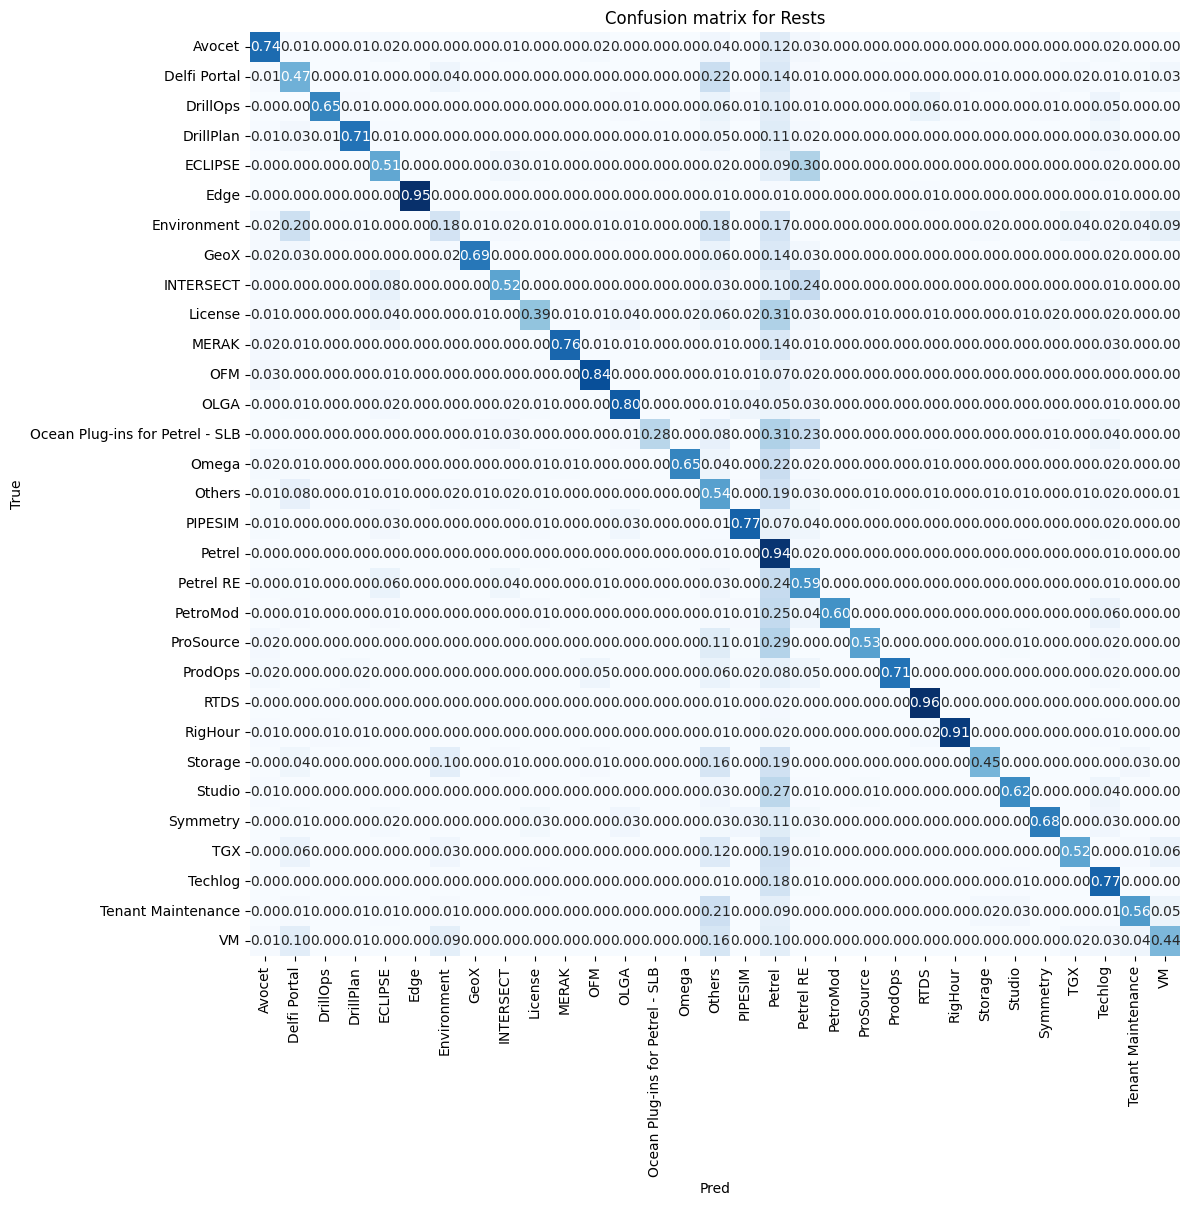

In [260]:
X_test = df_test['Title_Cleaned']
y_test = df_test['Product Name']

# Step 2: Word Embeddings with Count Vectorizer (FastText-like)
# vectorizer = CountVectorizer(max_features=8000, analyzer='word', ngram_range=(1, 2))
# X_encoded = vectorizer.fit_transform(X)
X_encoded = vectorizer.transform(X_test)
y_pred_petrel = model_petrel_or_not.predict(X_encoded)
y_pred_others = model_balanced.predict(X_encoded)

y_pred = predictions_2L(y_pred_petrel, y_pred_others)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_others, digits=3)
print(report)
# generate a confusion matrix for more detailed metrics


plot_confusion_matrix(y_test, y_pred, title='Confusion matrix for Rests')

In [ ]:
# dig into the wrongly predicted. 
# Seems many cases the original reported prodcuts were not entirely correct :)

import pandas as pd

# Assuming you have already defined X, y_pred, and y_test
# Convert y_test and y_pred to DataFrames with a common index
df_comparison = pd.DataFrame({'Text': X, 'Actual': y_test, 'Predicted': y_pred})

# Filter misclassified records
misclassified_records = df_comparison[df_comparison['Actual'] != df_comparison['Predicted']]

# Print the misclassified records
for index, row in misclassified_records.iterrows():
    print(f"Text: {row['Text']}")
    print(f"Reported: \033[94m{row['Actual']}\033[0m, Predicted: \033[95m{row['Predicted']}\033[0m\n")


In [297]:
import joblib
joblib.dump(model_balanced, '../models/logistic_regression_model.pkl')
joblib.dump(vectorizer, '../models/vectorizer.pkl')


['../models/vectorizer.pkl']

In [290]:
# def predict_top5(model, vectorizor, X_test):

#     texts_encoded = vectorizer.transform(X_test)

#     # create empty DataFrame to store the predictions
#     df_predictions = pd.DataFrame(columns=['Text', 'Pred_1', 'proba_1', 'Pred_2', 'proba_2', 'Pred_3', 'proba_3', 'Pred_4', 'proba_4', 'Pred_5', 'proba_5'])
    
#     df_predictions['Text'] = X_test
    
#     # Get the probabilities for each class
#     probabilities = model.predict_proba(texts_encoded)

#     # Define the number of top classes you want
#     top_classes = 5

#     # Get the indices of the top k probabilities in the order from highest to lowest
#     top_k_indices = np.argsort(probabilities, axis=1)[:, -top_classes:][:,::-1]
    
#     # Get the corresponding labels
#     labels = np.array(model_balanced.classes_)
#     top_k_labels = [labels[top_indices] for top_indices in top_k_indices]
    
#     # Print the top k labels with their probabilities 
#     for i, (probs, labs) in enumerate(zip(probabilities, top_k_labels)):
#         for j in range(top_classes):
#             df_predictions.iloc[i, j*2+1] = labs[j]
#             df_predictions.iloc[i, j*2+2] = probs[top_k_indices[i][j]]
    
#     return df_predictions

In [1]:
from src.helper_pred import predict_top5

X_test = df_test['Title_Cleaned']
y_test = df_test['Product Name']

df_pred = predict_top5(model_balanced, vectorizer, X_test, pre_process = True)
df_pred['Actual'] = y_test

# check if Actual is in the top 1
df_pred['in_top1'] = df_pred.apply(lambda x: x['Actual'] == x['Pred_1'], axis=1)
# check if Actual is in the top 3
df_pred['in_top3'] = df_pred.apply(lambda x: x['Actual'] in [x['Pred_1'], x['Pred_2'], x['Pred_3']], axis=1)
# check if Actual is in the top 5
df_pred['in_top5'] = df_pred.apply(lambda x: x['Actual'] in [x['Pred_1'], x['Pred_2'], x['Pred_3'], x['Pred_4'], x['Pred_5']], axis=1)


ModuleNotFoundError: No module named 'src'

In [ ]:
df_pred

,Text,Pred_1,proba_1,Pred_2,proba_2,Pred_3,proba_3,Pred_4,proba_4,Pred_5,proba_5,Actual,in_top1,in_top3,in_top5
57921,adaptive channel control,Petrel,0.447332,Techlog,0.08799,INTERSECT,0.069331,RTDS,0.066781,ECLIPSE,0.041308,Petrel,True,True,True
106278,petrel ix iteration parameter setting output f...,Petrel RE,0.98405,INTERSECT,0.01173,ECLIPSE,0.002228,Petrel,0.000962,VISAGE,0.000812,Petrel RE,True,True,True
103073,fast stratified statistical curve average,Techlog,0.798837,Petrel,0.059012,Petrel RE,0.042999,Ocean Framework for Petrel,0.016601,OFM,0.014645,Techlog,True,True,True
73250,bubble petronas able tgx mode,TGX,0.607017,Delfi Portal,0.122863,Environment,0.114604,Others,0.052497,VM,0.016529,TGX,True,True,True
17772,seplat energy plc step authentication,Delfi Portal,0.53042,Petrel,0.060987,Petrel RE,0.039903,Others,0.037588,RigHour,0.035865,Delfi Portal,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97365,log editor petrel,Petrel,0.637664,Petrel RE,0.171592,Studio,0.032891,License,0.023676,Ocean Plug-ins for Petrel - SLB,0.020212,Petrel,True,True,True
12278,drill ops equinor statfjord predictive analysi...,DrillOps,0.999602,RigHour,0.000276,RTDS,0.000088,Others,0.000013,Tenant Maintenance,0.000003,DrillOps,True,True,True
98456,equilibrium initialization parameter setting c...,Petrel RE,0.527691,ECLIPSE,0.47215,PetroMod,0.000062,Techlog,0.000024,PIPESIM,0.000013,ECLIPSE,False,True,True
60580,trouble logging delfi,Delfi Portal,0.319009,Others,0.135374,Techlog,0.076588,Petrel,0.075584,TGX,0.04756,Delfi Help,False,False,False


In [287]:
df_pred['in_top1'].mean(), df_pred['in_top3'].mean(), df_pred['in_top5'].mean()

(0.7504854977134624, 0.906283280085197, 0.9426799473783124)

In [288]:
texts = [
    'delfi.slb.com is down',
    'Petrel',
    "When opening TGX there were many (dozens) of message boxes saying 'Authentication failed Failed to get token.",
    'Psuite VM - pending Windows Explorer kills the vm',
    'Error when displaying the UI for a custom workstep',
    'security restart warning',
    'Production data not displaying correctly in DCA manual outlier selection.',
    'Cannot change account details after .com change (greyed out)',
    'd External connection to Remote Graphics receiver (outside the WorkSpace)',
    'user project removed during switch subscription profile',
    'Virtual machine wont start',
    'cannot log back in delfi',
    'cannot open petrel',
    'converting multiple polygons to geopolygons',
    'Pointset Map Migrationprod',
    'Well-Surface Intersection Workflow',
    'dataiku'
]
predictions = predict_top5(texts)

predictions

,Text,Pred_1,proba_1,Pred_2,proba_2,Pred_3,proba_3,Pred_4,proba_4,Pred_5,proba_5
0,delfi.slb.com is down,Delfi Portal,0.582646,RigHour,0.052613,Petrel,0.037956,VM,0.035551,Petrel RE,0.029372
1,Petrel,Petrel,0.601209,Petrel RE,0.184671,License,0.024114,INTERSECT,0.020356,ECLIPSE,0.020198
2,When opening TGX there were many (dozens) of m...,TGX,0.923253,Environment,0.02855,Delfi Help,0.012293,Delfi Portal,0.011244,Petrel,0.004982
3,Psuite VM - pending Windows Explorer kills the vm,VM,0.673413,Others,0.198521,Environment,0.045598,Delfi Portal,0.044352,Tenant Maintenance,0.007786
4,Error when displaying the UI for a custom work...,Ocean Framework for Petrel,0.631037,Others,0.091712,Avocet,0.057662,ECLIPSE,0.051645,MERAK,0.034181
5,security restart warning,ECLIPSE,0.299744,INTERSECT,0.140235,VM,0.113469,Petrel RE,0.08235,Environment,0.031448
6,Production data not displaying correctly in DC...,ProdOps,0.526938,Techlog,0.135127,Petrel RE,0.072176,OFM,0.063408,Petrel,0.063407
7,Cannot change account details after .com chang...,Delfi Portal,0.655659,Petrel,0.07606,Others,0.047167,Tenant Maintenance,0.040165,Avocet,0.024601
8,d External connection to Remote Graphics recei...,Delfi Portal,0.306041,Others,0.087796,ECLIPSE,0.079646,RTDS,0.067402,Environment,0.062925
9,user project removed during switch subscriptio...,Delfi Portal,0.61235,Others,0.064325,CCM - Catalog Management,0.055202,Environment,0.045967,Tenant Maintenance,0.037184
